In [1]:
import sys
sys.path.append('../')

from src.m4_generator import M4Generator
from src.m4_data_loader import M4DataLoader
from src.error_functions import *
from src.visualization import *
from src.evaluation import *
from src.m4_model import M4Model


import numpy as np
import keras
import matplotlib.pyplot as plt

import tensorflow as tf

%matplotlib inline
keras.backend.set_floatx('float64')

Using TensorFlow backend.


# Load Data

In [2]:
EPOCHS = 200
BATCH_SIZE = 128
LOOKBACK = 48
HORIZON = 48
HIDDEN_LAYER_SIZE = 60
FEATURES_NUMBER = 2
OUTPUT_SIZE = HORIZON*2
PI_CONFEDENCE=1.1
STD_WEIGHT = 1
LOSS = kl_loss(PI_CONFEDENCE, STD_WEIGHT)
PI_PARAMS = {'max_coff': 0.25, 'min_coff': 0.15, 'step': 0.1}

data_loader = M4DataLoader("../Dataset/Train/Hourly-train.csv", "../Dataset/Test/Hourly-test.csv",
                  LOOKBACK, HORIZON,  validation_ratio=0.05, pi_params=PI_PARAMS)

train_x, train_y = data_loader.get_training_data()
test_x, test_y = data_loader.get_test_data()
validate_x, validate_y = data_loader.get_validation_data()

training_data_generator = M4Generator(train_x, train_y, BATCH_SIZE, FEATURES_NUMBER)
test_data_generator = M4Generator(test_x, test_y, BATCH_SIZE, FEATURES_NUMBER)
validation_data_generator = M4Generator(validate_x, validate_y, BATCH_SIZE, FEATURES_NUMBER)

-1.1232156668806597
-1.3586846548012366
-0.8877466789600827


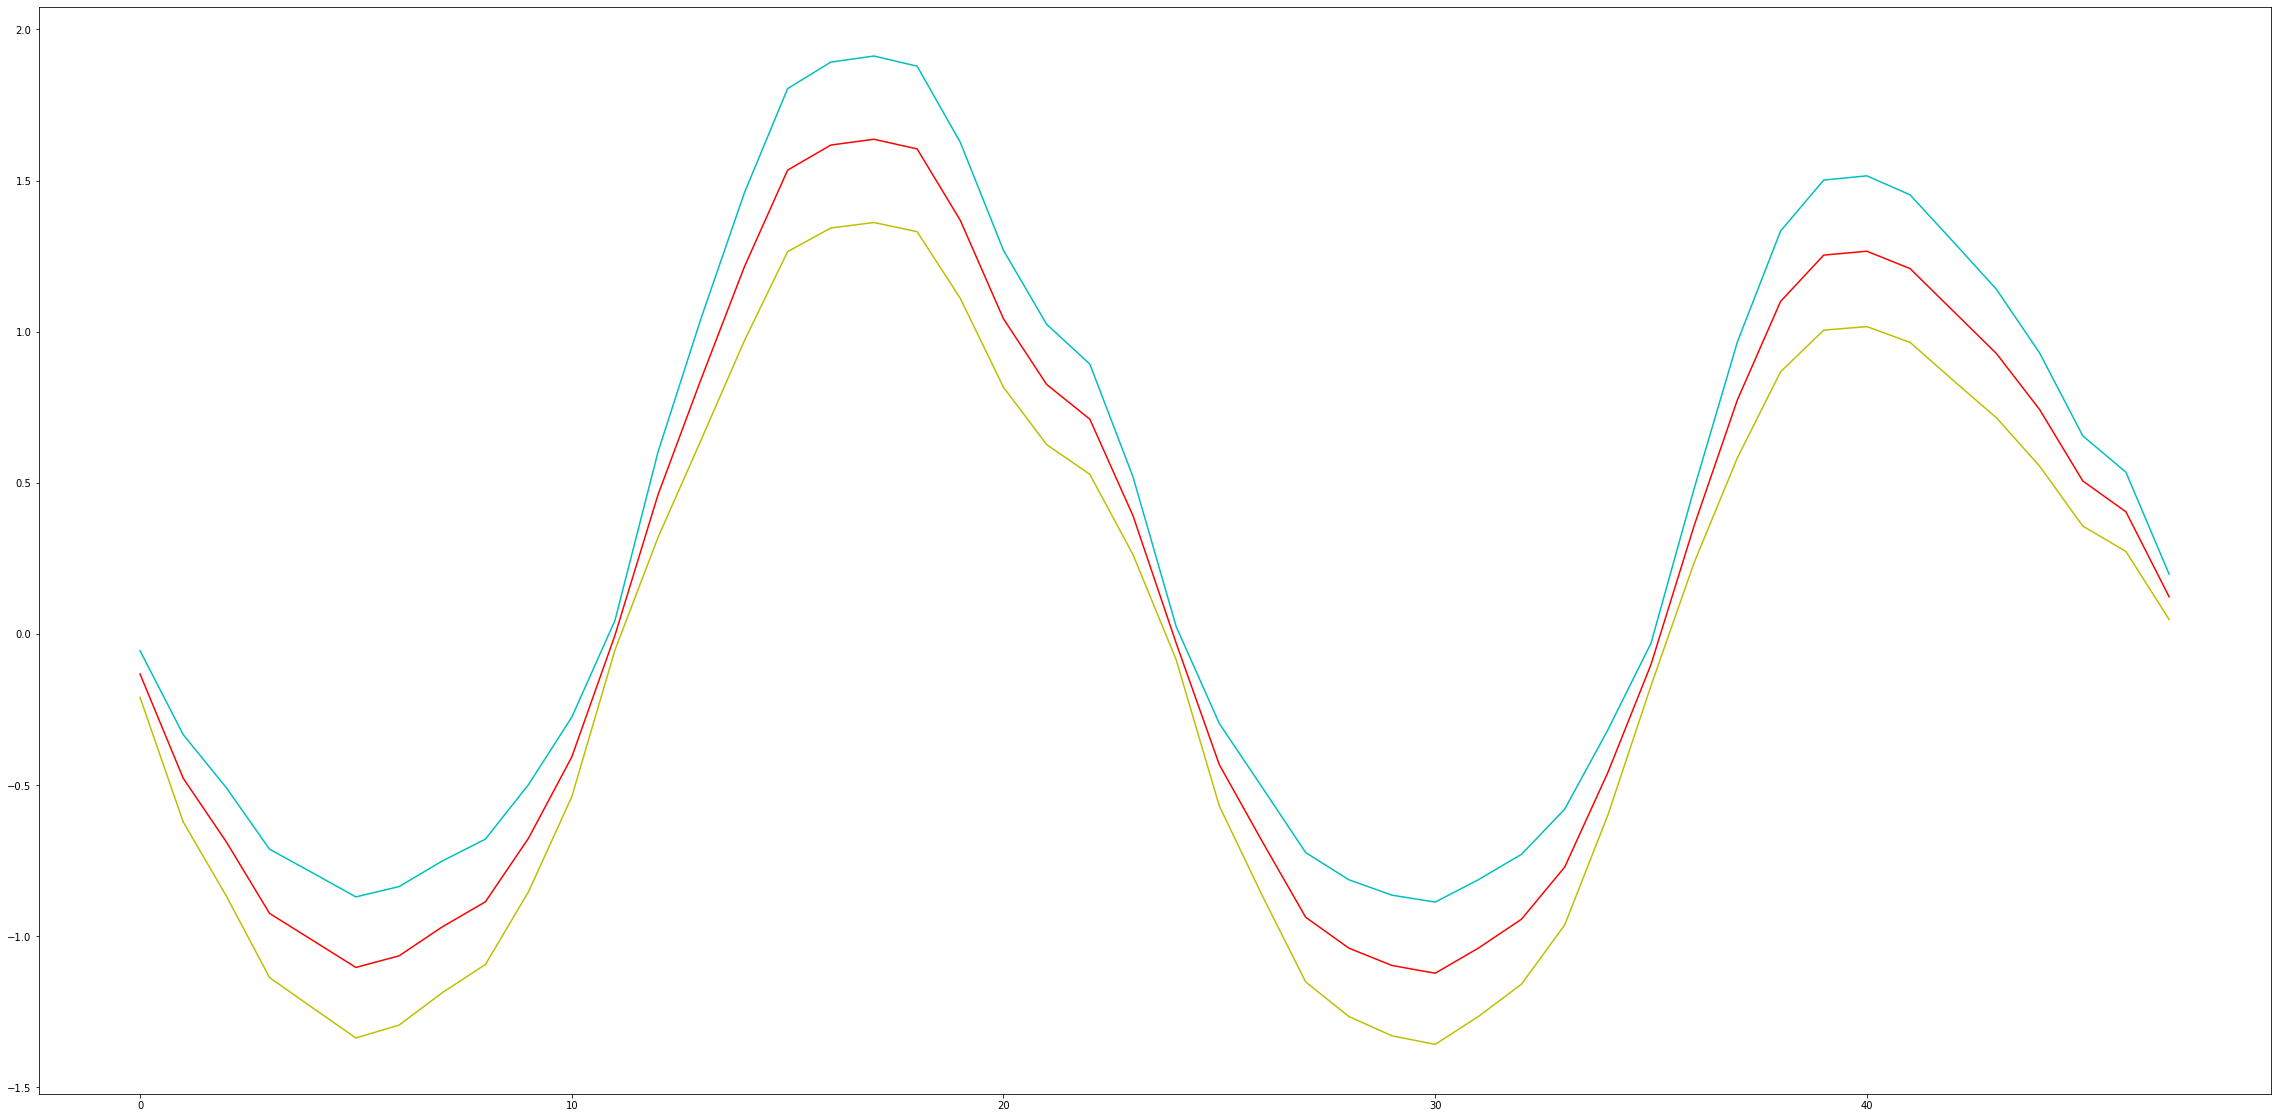

In [3]:

fig, axs = plt.subplots(1, 1, figsize=(40, 20))
    
true_series_time_axes = np.arange(0, 48)
axs.plot(true_series_time_axes, test_y[0,:48], color='r')
axs.plot(true_series_time_axes, test_y[0,:48] - test_y[0,48:], color='y')
axs.plot(true_series_time_axes, test_y[0,:48] + test_y[0,48:], color='c')

print(test_y[0,:48].min() )
print( (test_y[0,:48] - test_y[0,48:]).min())
print( (test_y[0,:48] + test_y[0,48:]).min())

In [4]:
from keras.callbacks.callbacks import Callback

class EarlyStoppingByLossVal(Callback):
    def __init__(self, monitor='val_loss', value=0.00001, verbose=0):
        super(Callback, self).__init__()
        self.monitor = monitor
        self.value = value
        self.verbose = verbose

    def on_epoch_end(self, epoch, logs={}):
        current = logs.get(self.monitor)
        if current is None:
            warnings.warn("Early stopping requires %s available!" % self.monitor, RuntimeWarning)

        if current < self.value:
            if self.verbose > 0:
                print("Epoch %05d: early stopping THR" % epoch)
            self.model.stop_training = True

# Train The Model

In [5]:
callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=0, mode='auto')
callback1 = EarlyStoppingByLossVal(monitor='val_loss', value=0.5, verbose=1)

model = M4Model(hidden_layer_size=HIDDEN_LAYER_SIZE, batch_size=BATCH_SIZE, lookback=LOOKBACK, 
                output_size=OUTPUT_SIZE, learning_rate=0.002, loss = LOSS,
                dropout_ratio = 0.3, features_number = FEATURES_NUMBER, callbacks = [callback1], pi_params=PI_PARAMS)

model.train(training_data_generator, test_data_generator, epochs=EPOCHS)

hist = model.evaluate(validation_data_generator)
print(hist)

Epoch 1/200
50/50 [==============================] - 14s 287ms/step - loss: 13243426508320.6797 - val_loss: 1.7160
Epoch 2/200
50/50 [==============================] - 13s 269ms/step - loss: 1.6184 - val_loss: 1.5773
Epoch 3/200
50/50 [==============================] - 13s 268ms/step - loss: 1.6105 - val_loss: 1.6676
Epoch 4/200
50/50 [==============================] - 13s 264ms/step - loss: 1.6180 - val_loss: 1.5372
Epoch 5/200
50/50 [==============================] - 13s 263ms/step - loss: 1.6118 - val_loss: 1.5686
Epoch 6/200
50/50 [==============================] - 13s 263ms/step - loss: 1.6118 - val_loss: 1.5670
Epoch 7/200
50/50 [==============================] - 13s 264ms/step - loss: 1.5074 - val_loss: 1.5328
Epoch 8/200
50/50 [==============================] - 13s 261ms/step - loss: 1.3946 - val_loss: 1.5202
Epoch 9/200
50/50 [==============================] - 13s 265ms/step - loss: 1.3129 - val_loss: 1.5056
Epoch 10/200
50/50 [==============================] - 13s 262ms/step 

50/50 [==============================] - 13s 252ms/step - loss: 0.7717 - val_loss: 0.8043
Epoch 81/200
50/50 [==============================] - 13s 250ms/step - loss: 0.7679 - val_loss: 0.7666
Epoch 82/200
50/50 [==============================] - 13s 262ms/step - loss: 0.7639 - val_loss: 0.7643
Epoch 83/200
50/50 [==============================] - 13s 263ms/step - loss: 1.6276 - val_loss: 0.9521
Epoch 84/200
50/50 [==============================] - 13s 260ms/step - loss: 0.7639 - val_loss: 0.7929
Epoch 85/200
50/50 [==============================] - 13s 268ms/step - loss: 0.7431 - val_loss: 0.7876
Epoch 86/200
50/50 [==============================] - 13s 250ms/step - loss: 0.7577 - val_loss: 0.7617
Epoch 87/200
50/50 [==============================] - 13s 250ms/step - loss: 0.7701 - val_loss: 0.8339
Epoch 88/200
50/50 [==============================] - 13s 250ms/step - loss: 0.7261 - val_loss: 0.7482
Epoch 89/200
50/50 [==============================] - 13s 255ms/step - loss: 0.7365 - 

50/50 [==============================] - 13s 254ms/step - loss: 0.6413 - val_loss: 0.6732
Epoch 160/200
50/50 [==============================] - 13s 254ms/step - loss: 0.6392 - val_loss: 0.7665
Epoch 161/200
50/50 [==============================] - 13s 255ms/step - loss: 0.6435 - val_loss: 0.7179
Epoch 162/200
50/50 [==============================] - 13s 255ms/step - loss: 0.6408 - val_loss: 0.6919
Epoch 163/200
50/50 [==============================] - 13s 255ms/step - loss: 0.6397 - val_loss: 0.7483
Epoch 164/200
50/50 [==============================] - 13s 254ms/step - loss: 0.6396 - val_loss: 0.6857
Epoch 165/200
50/50 [==============================] - 13s 253ms/step - loss: 0.6328 - val_loss: 0.6775
Epoch 166/200
50/50 [==============================] - 13s 256ms/step - loss: 0.6305 - val_loss: 0.7121
Epoch 167/200
50/50 [==============================] - 16s 311ms/step - loss: 0.6349 - val_loss: 0.6982
Epoch 168/200
50/50 [==============================] - 18s 357ms/step - loss: 

# Save The Model

In [6]:
MODEL_BASE_DIR = '../models/with_kl_pi_params/3-LSTM'
model.save(MODEL_BASE_DIR)

Saved model files to disk under../models/with_kl_pi_params/3-LSTM/7


# Get Best And Worst Predictions

Best Predection Error is     8.8788
Worst Predection Error is   159.2599


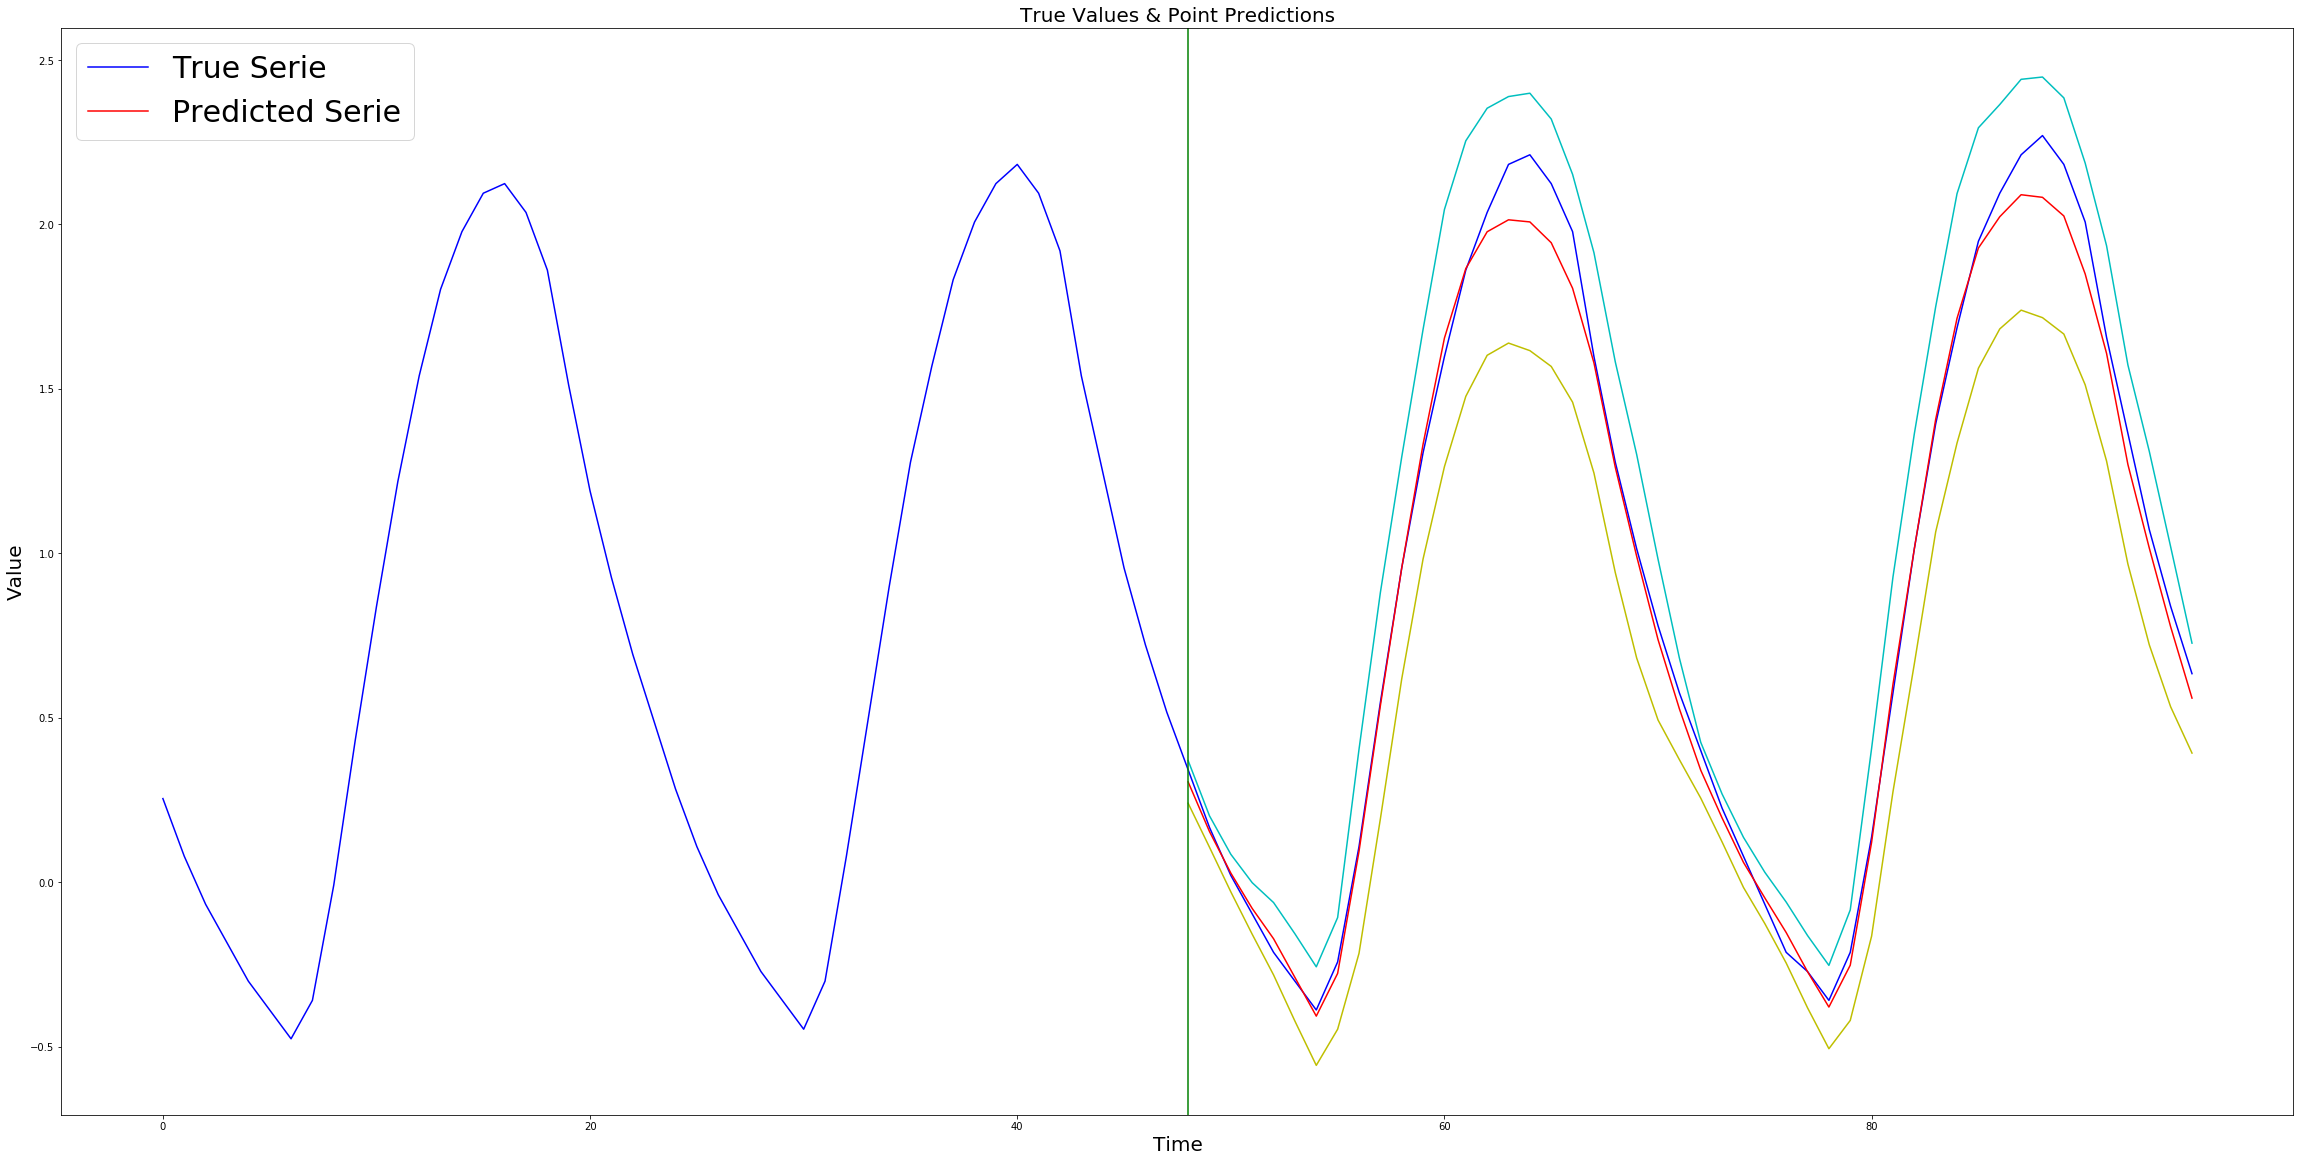

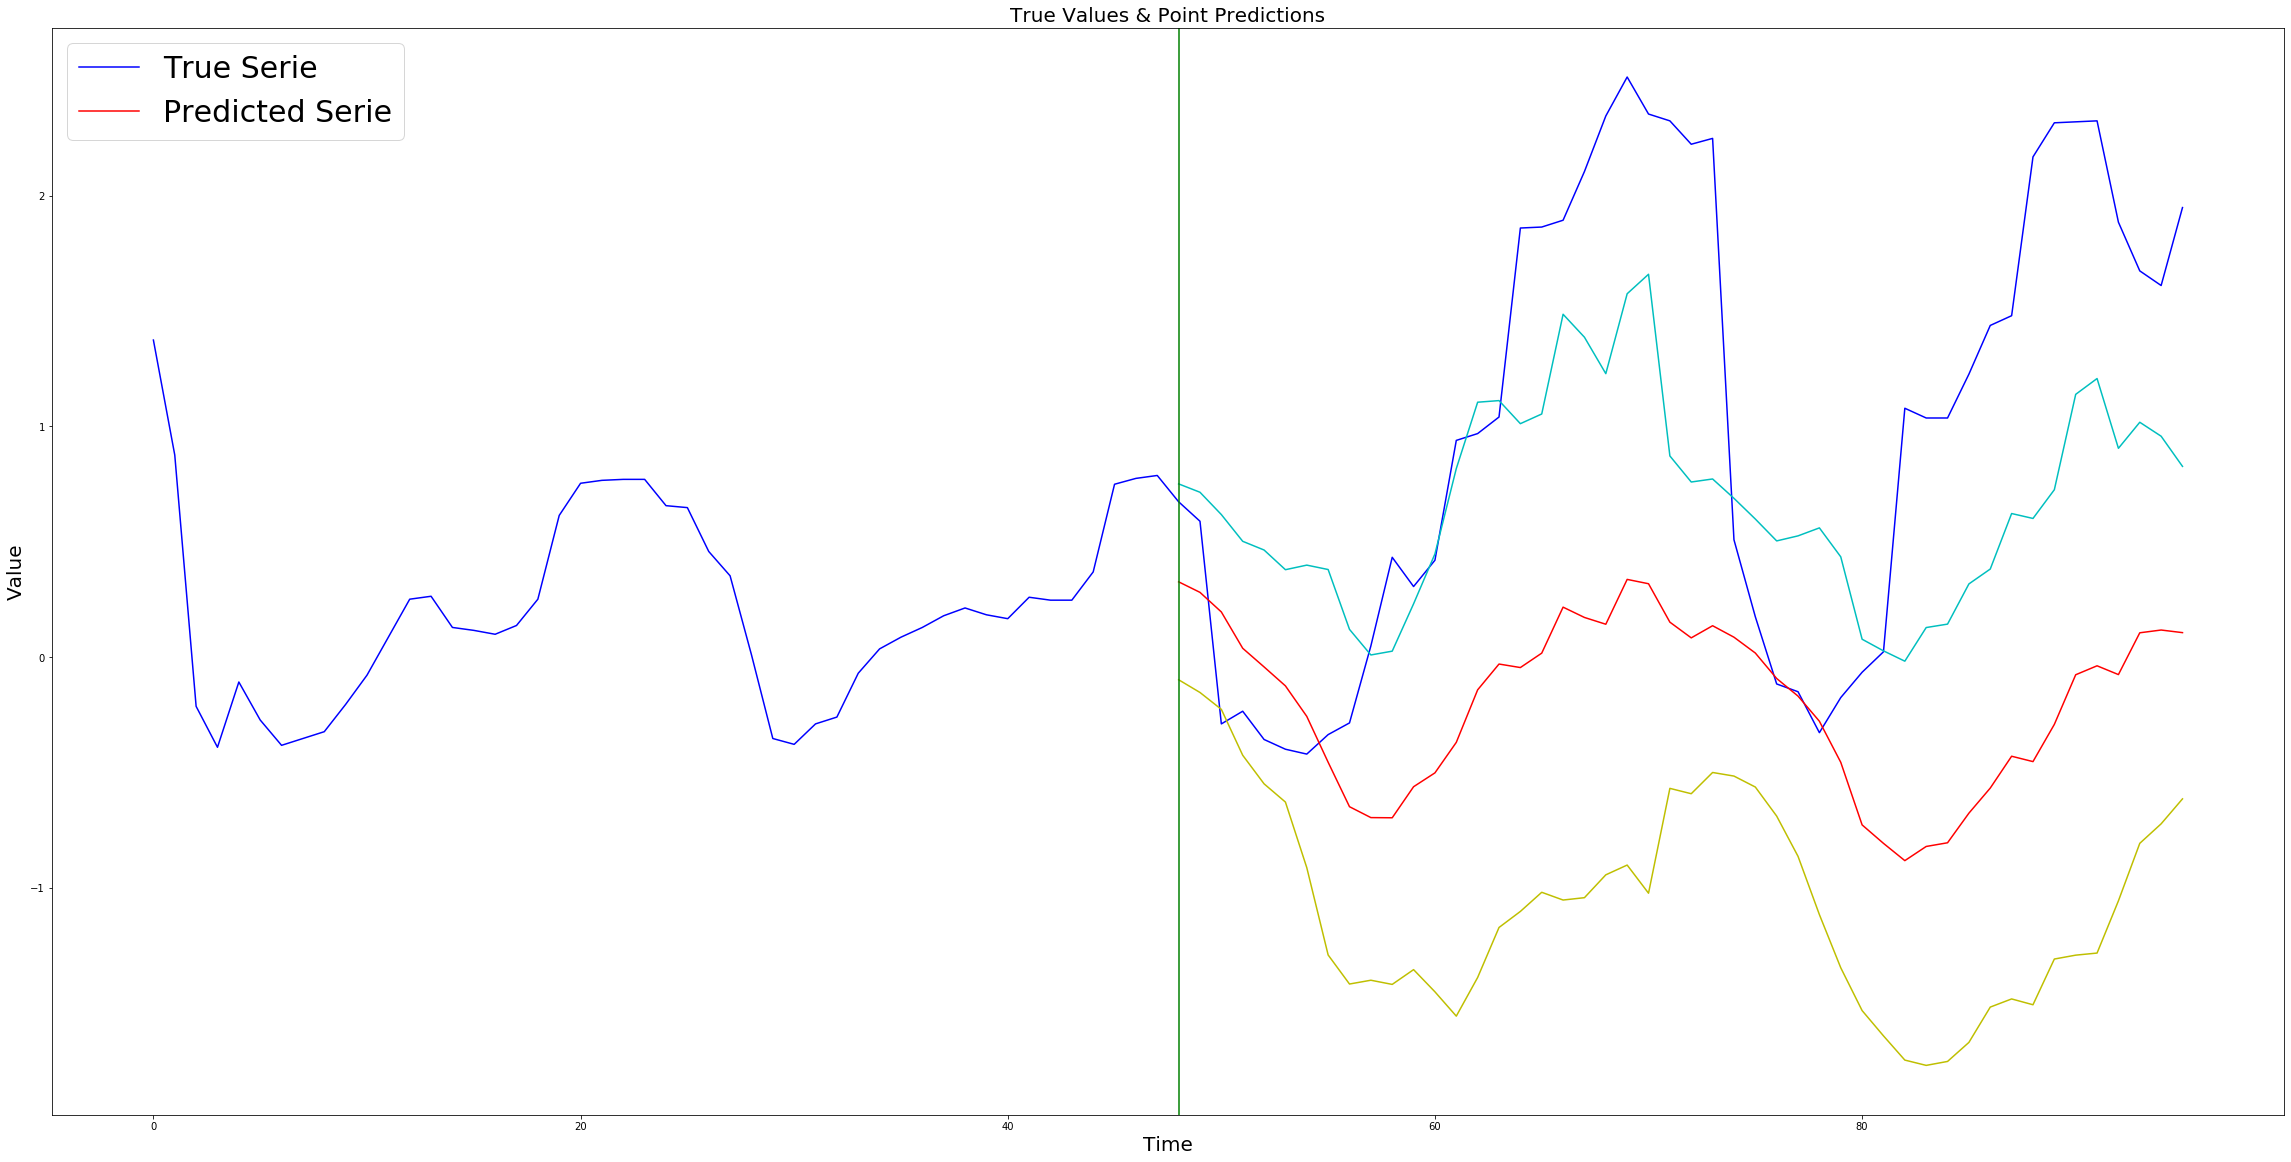

In [7]:
#model = M4Model()
#model.load('../models/with_kl/3-LSTM/7')

x, y, prediction, error =  sort_by_prediction_error(model,test_x, test_y, 
                                                    smape, features_number=FEATURES_NUMBER,
                                                    output_size = OUTPUT_SIZE)


print(f'Best Predection Error is {error[0]:10.4f}')
print(f'Worst Predection Error is {error[x.shape[0]-1]:10.4f}')

#plot_serie_and_prediction(x[:,:48], y[:,:48], prediction[:,:48], serie_indx=0)
#plot_serie_and_prediction(x[:,:48], y[:,:48], prediction[:,:48], serie_indx= x.shape[0]-1)
#plot_serie_and_prediction(x[:,:48], y[:,:48], prediction[:,:48] + prediction[:,-48:], serie_indx= 0)
#plot_serie_and_prediction(x[:,:48], y[:,:48], prediction[:,:48] - prediction[:,-48:], serie_indx= 0)
lower_bound = prediction[:,:48] - tf.abs(prediction[:,-48:])
upper_bound = prediction[:,:48] + tf.abs(prediction[:,-48:])
plot_serie_with_bounds(x[:,:LOOKBACK], y[:,:48], prediction[:,:48], lower_bound, upper_bound, serie_indx=0)
plot_serie_with_bounds(x[:,:LOOKBACK], y[:,:48], prediction[:,:48], lower_bound, upper_bound, serie_indx=x.shape[0]-1)

# PLot Specific Serie From A Batch

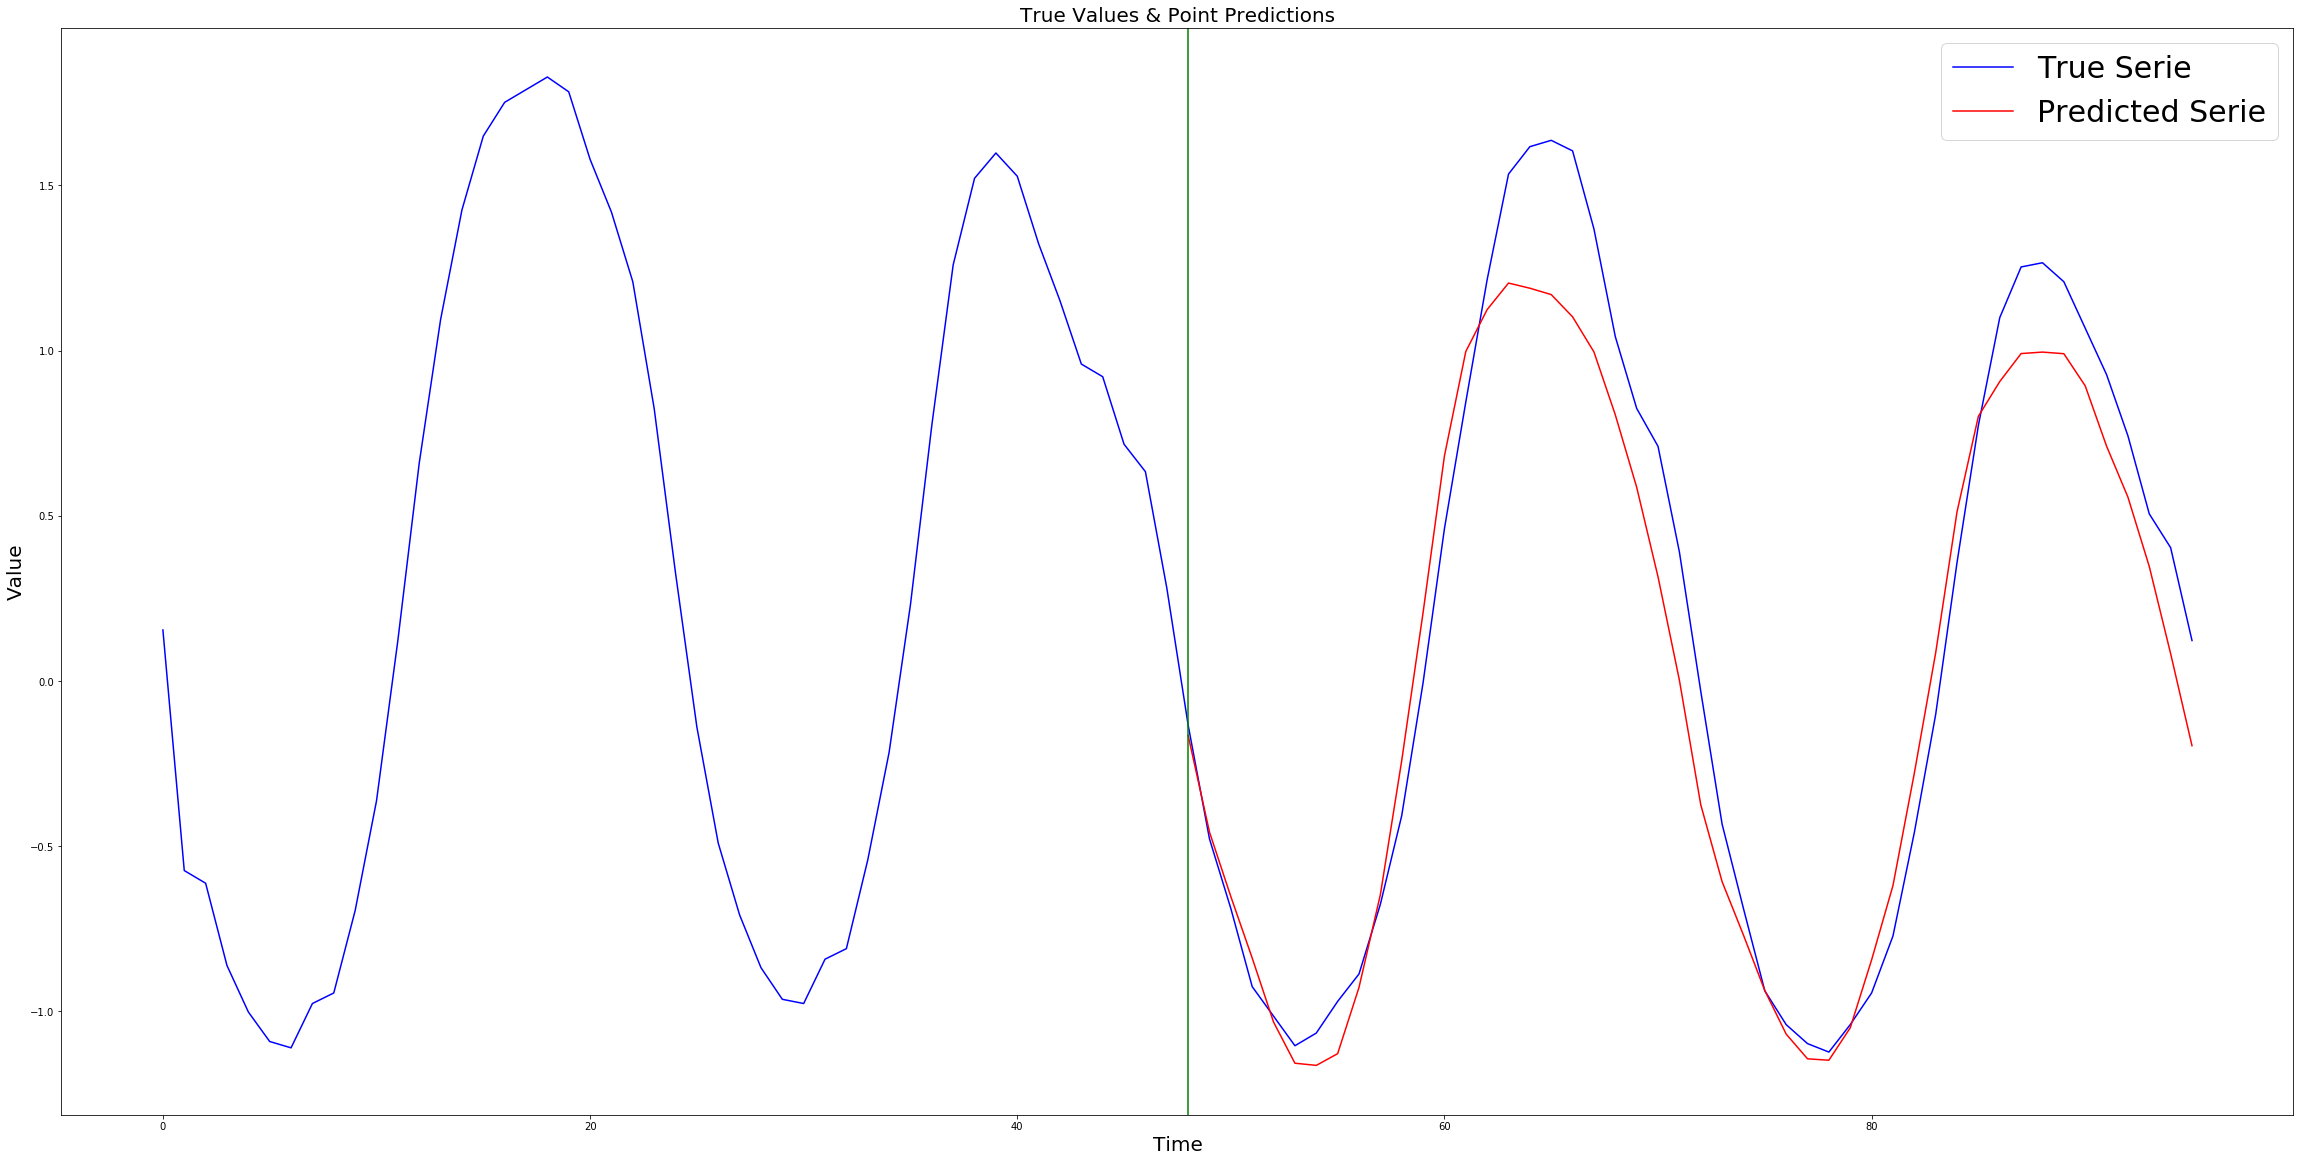

In [8]:
IDX = 0
x = test_x[:BATCH_SIZE,:]
y = test_y[:BATCH_SIZE,:]
#============ Predict Test
predictedY = model.predict(x.reshape(BATCH_SIZE, LOOKBACK, -1 ))
#plot_series(test_x, test_y, predictedY, series_num=10)
plot_serie_and_prediction(x[:,:,0], y[:,:48], predictedY[:,:48], serie_indx=IDX)

In [9]:
lower_bound = y[:BATCH_SIZE,:48] - np.abs(predictedY[:,-48:])
upper_bound = y[:100,:48] + np.abs(predictedY[:,-48:])
#plot_serie_with_bounds(test_y[:,:48], test_y[:,:48], test_y[:,:48], lower_bound, upper_bound, serie_indx=0)
data = y[0,:48]
lower = lower_bound[0,:48]
upper = upper_bound[0,:48]
fig, axs = plt.subplots(1, 1, figsize=(40, 20))

time_axs = np.arange(0, 48)
axs.plot(time_axs, data, color='r')
axs.plot(time_axs, lower, color='y')
axs.plot(time_axs, upper, color='c')
validate_x.max()

ValueError: operands could not be broadcast together with shapes (100,48) (128,48) 

# Evaluate A Model Against An Error Function

In [17]:
MODEL_NUMBER = 5
MODEL_BASE_DIR = '../models/with_kl_pi_params/3-LSTM'
hyperparameters, training_error, test_error, validation_error = load_and_evaluate_model(f'{MODEL_BASE_DIR}/{MODEL_NUMBER}', 
                                                                       '../Dataset/Train/Hourly-train.csv', 
                                                                       '../Dataset/Test/Hourly-test.csv', mase, pi_params=PI_PARAMS)
print(f'Hyperparameters : {hyperparameters}')
print(f'Training Error For Model ({MODEL_NUMBER}) : {training_error}')
print(f'Test Error For Model ({MODEL_NUMBER}) : {test_error}')
print(f'Validation Error For Model ({MODEL_NUMBER}) : {validation_error}')

Loaded model from disk
Hyperparameters : {'epochs': 100, 'batch_size': 100, 'hidden_layer_size': 50, 'lookback': 48, 'loss': 'kl_divergance', 'dropout_ratio': 0.3, 'features_number': 2, 'output_size': 96, 'pi_params': {'max_coff': 0.25, 'min_coff': 0.15, 'step': 0.1}}
Training Error For Model (5) : 1.081
Test Error For Model (5) : 1.152
Validation Error For Model (5) : 1.155
